# TLDR Articles Exploration Notebook

## Data Exploration

In [47]:
import pandas as pd

df = pd.read_csv("../data/tldr_articles.csv")

df.head()

,section,article,is_relevant
0,BIG TECH & STARTUPS,TESLA IN DISCUSSION TO LICENSE FULL SELF-DRIVI...,1
1,BIG TECH & STARTUPS,APPLE HAS BEEN WORKING ON ITS OWN CHATGPT AI T...,1
2,SCIENCE & FUTURISTIC TECHNOLOGY,BACK FROM THE DEAD: NEW HOPE FOR RESURRECTING ...,1
3,SCIENCE & FUTURISTIC TECHNOLOGY,HEARING AIDS MAY REDUCE YOUR RISK OF DEMENTIA ...,1
4,"PROGRAMMING, DESIGN & DATA SCIENCE",RETAKE (GITHUB REPO)\r\n[https://github.com/ge...,1


The dataset contains three columns:

1. **section**: This column describes the category of the article. Categories include "BIG TECH & STARTUPS", "SCIENCE & FUTURISTIC TECHNOLOGY", and "PROGRAMMING, DESIGN & DATA SCIENCE" and potentially more.

2. **article**: This column contains the text of the articles.

3. **is_relevant**: This is the target label, indicating whether the article is relevant (1) or not (0).

One thing to notice, is that we want **high Recall on the Relevant class**, because we don't want to miss any emails.

Let's now explore the dataset for missing values, distribution of the target variable, distribution of the 'section' feature and number of unique sections.

In [48]:
# Check for missing values
missing_values = df.isnull().sum()

# Check the distribution of the target variable
target_distribution = df['is_relevant'].value_counts(normalize=True)

# Check the distribution of the 'section' feature
section_distribution = df['section'].value_counts()

# Number of unique sections
num_unique_sections = df['section'].nunique()

missing_values, target_distribution, section_distribution, num_unique_sections

(section        0
 article        0
 is_relevant    0
 dtype: int64,
 is_relevant
 0    0.595987
 1    0.404013
 Name: proportion, dtype: float64,
 section
 QUICK LINKS                           892
 BIG TECH & STARTUPS                   334
 MISCELLANEOUS                         334
 SCIENCE & FUTURISTIC TECHNOLOGY       333
 PROGRAMMING, DESIGN & DATA SCIENCE    300
 Name: count, dtype: int64,
 5)

Here's what we've found:

* There are no missing values in the dataset, which is great as it simplifies the preprocessing steps.

* The distribution of the target variable, 'is_relevant', is as follows: ~59.6% of the articles are labeled as not relevant (0), and ~40.4% are labeled as relevant (1). This slight imbalance should not pose a significant issue for most machine learning algorithms.

* The 'section' feature has five unique categories: "BIG TECH & STARTUPS", "SCIENCE & FUTURISTIC TECHNOLOGY", "PROGRAMMING, DESIGN & DATA SCIENCE", "QUICK LINKS", and "MISCELLANEOUS". The distribution of these categories shows that "QUICK LINKS" is the most common category with 892 articles, followed by "BIG TECH & STARTUPS" and "MISCELLANEOUS" each with 334 articles, "SCIENCE & FUTURISTIC TECHNOLOGY" with 333 articles, and "PROGRAMMING, DESIGN & DATA SCIENCE" with 300 articles.

Now let's create some visualisations:

In [49]:
df['is_relevant']

0       1
1       1
2       1
3       1
4       1
       ..
2188    0
2189    0
2190    0
2191    0
2192    0
Name: is_relevant, Length: 2193, dtype: int64

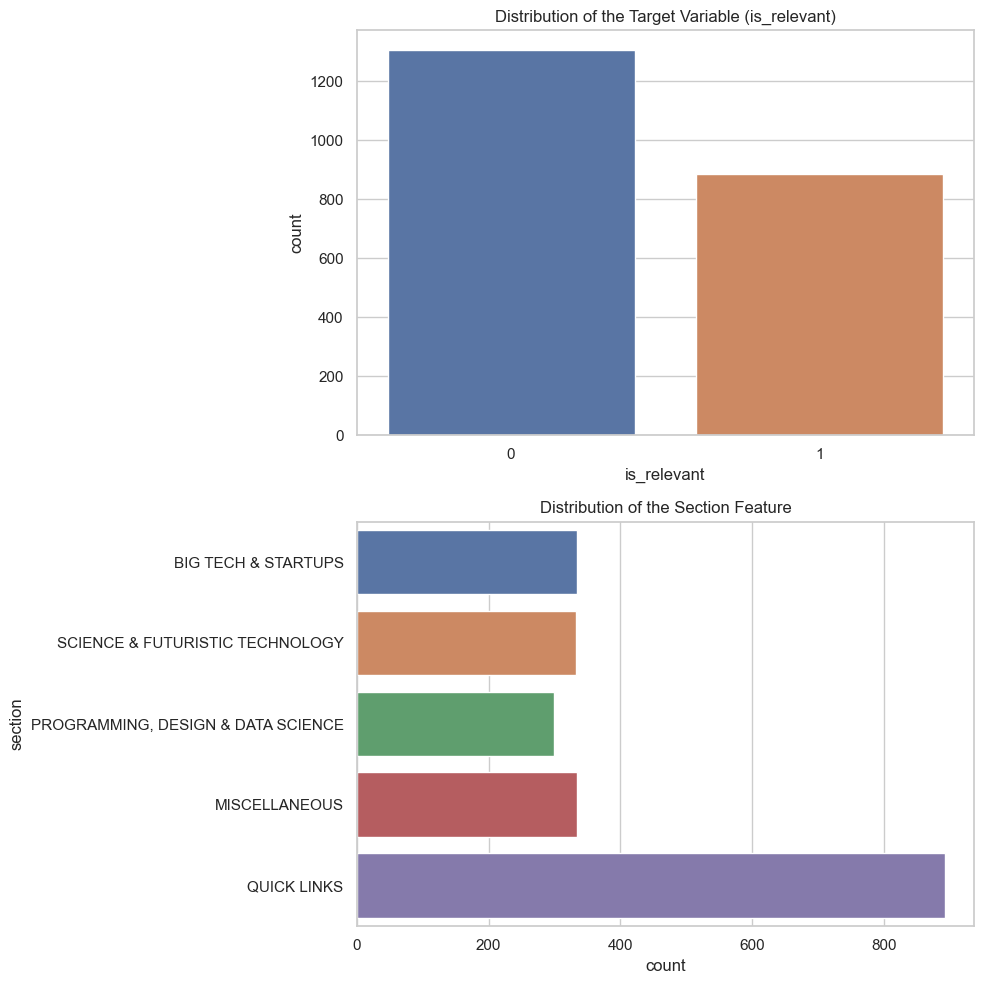

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style of the plots
sns.set(style="whitegrid")

# Create a figure with two subplots
fig, ax = plt.subplots(2, 1, figsize=(10, 10))

# Plot the distribution of the target variable
sns.countplot(df, x="is_relevant", ax=ax[0])
ax[0].set_title('Distribution of the Target Variable (is_relevant)')

# Plot the distribution of the 'section' feature
sns.countplot(df, y="section", ax=ax[1])
ax[1].set_title('Distribution of the Section Feature')

plt.tight_layout()
plt.show()


Here are the visualizations of the distributions we discussed earlier:

1. **Distribution of the Target Variable ('is_relevant')**: As we can see in the first plot, the dataset contains more articles that are not relevant (0) than relevant ones (1).

2. **Distribution of the 'section' Feature**: The second plot shows the distribution of the different sections. "QUICK LINKS" is the most common category, followed by "BIG TECH & STARTUPS", "MISCELLANEOUS", "SCIENCE & FUTURISTIC TECHNOLOGY", and "PROGRAMMING, DESIGN & DATA SCIENCE".

## Model Exploration and Training

'section' will be encoded as a categorical feature and 'article', which is a normal text feature, will be preprocessed.

In [51]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin

class TextSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single text column from the data frame to perform additional transformations on
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single numerical column from the data frame to perform additional transformations on
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]

class CustomLabelEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.encoder = LabelEncoder()

    def fit(self, X, y=None):
        self.encoder.fit(X)
        return self

    def transform(self, X):
        return self.encoder.transform(X).reshape(-1, 1)

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(df[['article', 'section']], df['is_relevant'], test_size=0.2, random_state=42)

# Define the preprocessing steps
text = Pipeline([
                ('selector', TextSelector(key='article')),
                ('tfidf', TfidfVectorizer(stop_words='english'))
            ])
section =  Pipeline([
                ('selector', TextSelector(key='section')),  # Use TextSelector instead of NumberSelector
                ('encoder', CustomLabelEncoder()),  # Add the CustomLabelEncoder to the pipeline
            ])
features = FeatureUnion([('article', text), ('section', section)])

For the training, we are going to try some basic models: Logistic Regression, Random Forest and XGBoost. We will use GridSearchCV to select the best parameters for each model. We are also going to track the training with MLFlow, so make sure to init the server locally first with `mlflow ui -p 5001`

Also, we use the `imblearn` library for oversampling. We have used RandomOverSample in the end. We had used SMOTE which creates synthetic instances of the minority class but it wasn't working as well for Recall.

In [62]:
import mlflow
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, make_scorer, recall_score
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline as imblearnPipeline

mlflow.set_tracking_uri("http://localhost:5001/")
experiment = mlflow.get_experiment_by_name("email_discriminator")

# Define the models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(),
    "XGBoost": XGBClassifier(eval_metric='logloss')
}

# Define scorer based on recall
scorer = make_scorer(recall_score)

# Define the parameter grids for GridSearchCV
param_grids = {
    "Logistic Regression": {"model__C": [0.1, 1, 10]},
    "Random Forest": {"model__n_estimators": [100, 200, 300]},
    "XGBoost": {"model__n_estimators": [100, 200, 300], "model__learning_rate": [0.01, 0.1, 0.2]}
}

# Train each model, perform hyperparameter tuning with GridSearchCV, and log the results with MLFlow
for model_name, model in models.items():
    with mlflow.start_run(run_name=model_name) as run:
        # Create a pipeline
        pipeline = imblearnPipeline([
            ('features', features),
            ('sampling', RandomOverSampler()),
            ('model', model)
        ])

        # Define GridSearchCV
        grid_search = GridSearchCV(pipeline, param_grids[model_name], cv=3, scoring=scorer)

        # Perform hyperparameter tuning
        grid_search.fit(X_train, y_train)

        # Make predictions with the best model
        y_pred = grid_search.predict(X_test)

        # Compute metrics
        report = classification_report(y_test, y_pred, output_dict=True)

        # Log metrics with MLFlow
        mlflow.log_metric("accuracy", report["accuracy"])
        mlflow.log_metric("precision", report["macro avg"]["precision"])
        mlflow.log_metric("recall", report["macro avg"]["recall"])
        mlflow.log_metric("f1-score", report["macro avg"]["f1-score"])

        # Log class-specific metrics with MLFlow
        for i, class_ in enumerate(['Not Relevant', 'Relevant']):
            mlflow.log_metric(f"{class_}_precision", report[str(i)]["precision"])
            mlflow.log_metric(f"{class_}_recall", report[str(i)]["recall"])
            mlflow.log_metric(f"{class_}_f1-score", report[str(i)]["f1-score"])

        # Log parameters with MLFlow
        mlflow.log_params(grid_search.best_params_)

        # Set a tag for the name of the model
        mlflow.set_tag("model_name", model_name)

        # Log the model with MLFlow
        mlflow.sklearn.log_model(grid_search.best_estimator_, "model")

/Users/unaigaraymaestre/Library/Caches/pypoetry/virtualenvs/email-discriminator-xyoku47L-py3.10/lib/python3.10/site-packages/_distutils_hack/__init__.py:18: UserWarning:

Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.

/Users/unaigaraymaestre/Library/Caches/pypoetry/virtualenvs/email-discriminator-xyoku47L-py3.10/lib/python3.10/site-packages/_distutils_hack/__init__.py:33: UserWarning:

Setuptools is replacing distutils.

/Users/unaigaraymaestre/Library/Caches/pypoetry/virtualenvs/email-discriminator-xyoku47L-py3.10/lib/python3.10/site-packages/_distutils_hack/__init__.py:18: UserWarning:

Distutils was imported before Setuptools, but importing Setupt

Now, we can go to MLFlow UI to see the results. But for convenience we can see the metrics for each model plotted here:

In [63]:
import math
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Get all runs for the experiment
runs = mlflow.search_runs(experiment_ids=experiment.experiment_id)

# Sort the DataFrame by start time
runs = runs.sort_values('start_time')

# Keep only the last entry for each model
runs = runs.drop_duplicates('tags.mlflow.runName', keep='last')

# Convert the metrics and parameters columns to numeric types for plotting
for col in runs.columns:
    if "param" in col or "metric" in col:
        runs[col] = pd.to_numeric(runs[col], errors='coerce')


# Define metrics
metrics = ['accuracy', 'precision', 'recall', 'f1-score']

# Calculate the number of rows and columns for the subplots
n_cols = 2
n_rows_metrics = math.ceil(len(metrics) / n_cols)

# Create subplots for metrics
fig_metrics = make_subplots(rows=n_rows_metrics, cols=n_cols, subplot_titles=metrics)

# Create a bar plot for each metric
for i, metric in enumerate(metrics):
    row = i // n_cols + 1
    col = i % n_cols + 1
    for model_name in runs['tags.mlflow.runName'].unique():
        model_runs = runs[runs['tags.mlflow.runName'] == model_name]
        avg_metric = round(model_runs[f'metrics.{metric}'].mean(), 2)
        fig_metrics.add_trace(go.Bar(name=model_name, 
                             x=[model_name], 
                             y=[avg_metric],
                             text=[round(avg_metric, 3)],  # add data labels
                             textposition='auto',  # position labels automatically
                             error_y=dict(type='data', 
                                          array=[model_runs[f'metrics.{metric}'].std()],
                                          visible=True)),
                      row=row, col=col)

# Update layout for metrics
fig_metrics.update_layout(barmode='group', title_text="Model Metrics Comparison", 
                  title_x=0.5, showlegend=False, height=1200)
fig_metrics.show()



It seems that **XGBoost** is the best model overall for **Recall**.

Now let's see how each model performs for each class: Relevant vs Not Relevant. We do this because we want to make sure we don't miss any relevant articles.

In [64]:
# Define class-specific metrics
class_metrics = ['Not Relevant_precision', 'Not Relevant_recall', 'Not Relevant_f1-score', 
                 'Relevant_precision', 'Relevant_recall', 'Relevant_f1-score']

# Calculate the number of rows and columns for the subplots
n_cols = 2
n_rows_class_metrics = math.ceil(len(class_metrics) / n_cols)

# Create subplots for class-specific metrics
fig_class_metrics = make_subplots(rows=n_rows_class_metrics, cols=n_cols, subplot_titles=class_metrics)

# Create a bar plot for each class-specific metric
for i, metric in enumerate(class_metrics):
    row = i // n_cols + 1
    col = i % n_cols + 1
    for model_name in runs['tags.mlflow.runName'].unique():
        model_runs = runs[runs['tags.mlflow.runName'] == model_name]
        avg_metric = round(model_runs[f'metrics.{metric}'].mean(), 2)
        fig_class_metrics.add_trace(go.Bar(name=model_name, 
                             x=[model_name], 
                             y=[avg_metric],
                             text=[round(avg_metric, 3)],  # add data labels
                             textposition='auto',  # position labels automatically
                             error_y=dict(type='data', 
                                          array=[model_runs[f'metrics.{metric}'].std()],
                                          visible=True)),
                      row=row, col=col)
        
# Update layout for class-specific metrics
fig_class_metrics.update_layout(barmode='group', title_text="Class-Specific Model Metrics Comparison", 
                  title_x=0.5, showlegend=False, height=1200)
fig_class_metrics.show()

It seems we perform poorly on the Relevant class. It's normal since the dataset is imbalanced. We've used RandomOverSampling to create synthetic instances of the minority class by random choosing instances. Before it was under 0.5 for the Relevant class, so we've improved.

Because we will be using a Feedback loop in the final project, we don't need to overoptimised. But let's see where we can get by tweaking the threshold so that we get the best Recall while keeping the F1-score of both classes at a reasonable level (above 0.6 will do).

In [75]:
import mlflow
import mlflow.sklearn
import numpy as np
from sklearn.metrics import f1_score

# Set the tracking URI and get the experiment
mlflow.set_tracking_uri("http://localhost:5001/")
experiment = mlflow.get_experiment_by_name("email_discriminator")

# Get all runs for the experiment
runs = mlflow.search_runs(experiment_ids=experiment.experiment_id)

# Sort the DataFrame by start time
runs = runs.sort_values('start_time')

# Keep only the last entry for each model
runs = runs.drop_duplicates('tags.mlflow.runName', keep='last')

# Select the XGBoost model
xgboost_run = runs[runs["tags.mlflow.runName"] == "XGBoost"]

# Get the artifact URI of the model
artifact_uri = xgboost_run.iloc[0]["artifact_uri"]

# Load the model
model = mlflow.sklearn.load_model(artifact_uri + "/model")

# Get the probabilities for each class
y_proba = model.predict_proba(X_test)

# Get the probabilities for the positive class
y_proba_pos = y_proba[:, 1]

thresholds = np.arange(0, 1, 0.01)
best_threshold = 0.5
best_f1_score = 0
best_recall = 0

for threshold in thresholds:
    y_pred = (y_proba_pos >= threshold).astype(int)
    f1 = f1_score(y_test, y_pred, average=None)  # F1-score for each class
    recall = recall_score(y_test, y_pred, pos_label=1)  # Recall for 'Relevant' class
    if recall > best_recall and min(f1) > 0.6:  # If recall improves and both F1-scores are above 0.6
        best_threshold = threshold
        best_f1_score = f1
        best_recall = recall

print(f"Best threshold: {best_threshold}")
print(f"Best F1-score: {best_f1_score}")
print(f"Best recall: {best_recall}")



Best threshold: 0.25
Best F1-score: [0.60829493 0.61711712]
Best recall: 0.7527472527472527


The desired threshold is **0.25**, which gets **0.75 Recall** for the Relevant class, which is much higher than 0.58.

F1-Score of Relevant class has decreased a little bit and F1-Score of Not Relevant has decreased considerably, but this is something we can allow since we don't want to miss Relevant articles.